### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [1]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city,array_to_latex
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
import pandas as pd
from qiskit.circuit.library.data_preparation.state_preparation import *
#9329 con 6 res
#seed 10 con resolution 5
np.random.seed(10)

example_matrix=np.random.rand(2,2)


example_matrix=np.dot(example_matrix,example_matrix.T)

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.19814128 0.14215395 0.14215395 0.51755082]


In [2]:
example_matrix,np.linalg.eig(example_matrix)

(array([[0.59536618, 0.5042851 ],
        [0.5042851 , 0.96221734]]),
 (array([0.24218351, 1.31540001]),
  array([[-0.81909218, -0.57366192],
         [ 0.57366192, -0.81909218]])))

In [3]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.38223708, 0.3237612 ],
        [0.3237612 , 0.61776292]]),
 (array([0.15548669, 0.84451331]),
  array([[-0.81909218, -0.57366192],
         [ 0.57366192, -0.81909218]])))

In [123]:
'''eig,e_v=np.linalg.eig(example_matrix1)
b=np.array([.6,.4])
#b=np.array([3.,2.,1.,0])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)
example_matrix2=BB

sum_squares = (example_matrix2**2).sum()
input_probabilities = (example_matrix2**2/sum_squares).flatten()
example_matrix2=example_matrix2/np.trace(example_matrix2)
print(input_probabilities)'''

'eig,e_v=np.linalg.eig(example_matrix1)\nb=np.array([.6,.4])\n#b=np.array([3.,2.,1.,0])\nBB = e_v@np.diag(b)@e_v.T\nBB, np.linalg.eig(BB)\nexample_matrix2=BB\n\nsum_squares = (example_matrix2**2).sum()\ninput_probabilities = (example_matrix2**2/sum_squares).flatten()\nexample_matrix2=example_matrix2/np.trace(example_matrix2)\nprint(input_probabilities)'

In [4]:
np.trace(example_matrix)*np.linalg.eig(example_matrix1)[0]

array([0.24218351, 1.31540001])

In [5]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [6]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [7]:
thetas, all_combinations = thetas_computation(example_matrix1)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

0 -> 0.5833482907525466
1 -> 0.8122221196668326
00 -> 0.44513063271780423
01 -> 0.3770330862671933
10 -> 0.3770330862671933
11 -> 0.7194100524290148


┌────────────┐┌───┐              ┌───┐              
q_0: ┤ Ry(1.8959) ├┤ X ├──────■───────┤ X ├──────■───────
     └────────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(1.4055) ├─────┤ Ry(2.1761) ├
                        └────────────┘     └────────────┘

In [8]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'00': 0.198141280183753,
 '01': 0.142153948140165,
 '10': 0.142153948140165,
 '11': 0.517550823535918}

In [9]:
#Unitary for PE
resolution = 7
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_6153/1992324753.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)


Operator([[ 5.59551549e-01+0.28330222j, -9.53843358e-17-0.77887221j],
          [-9.53843358e-17-0.77887221j,  5.59551549e-01-0.28330222j]],
         input_dims=(2,), output_dims=(2,))

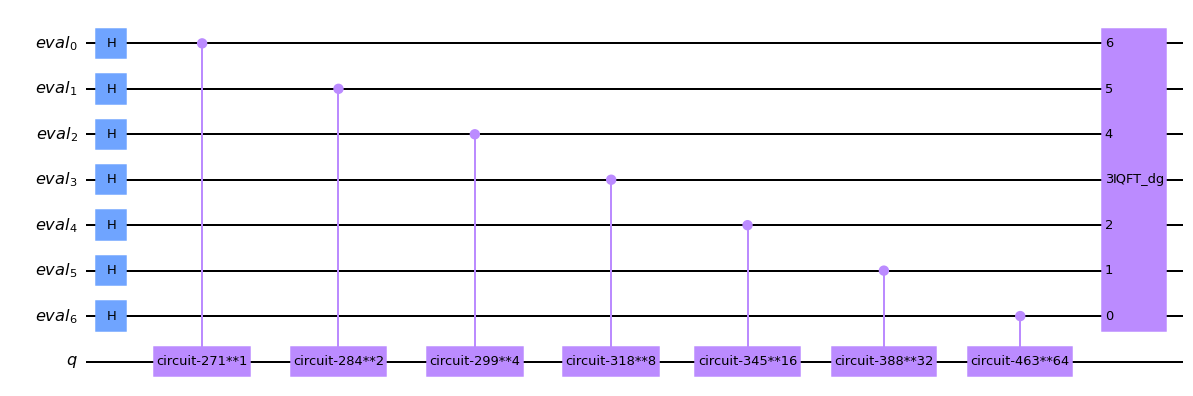

In [10]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

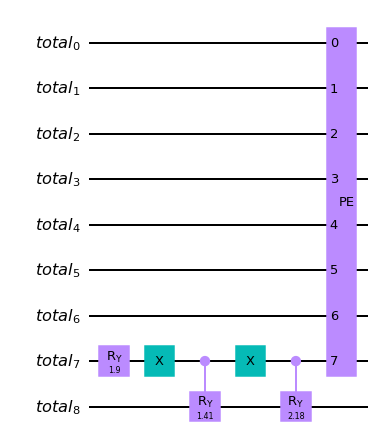

In [11]:
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_sim = QuantumCircuit(qr_total_sim , name='matrix')

total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

In [12]:
# Create the first operator for tomography
op_U=total_circuit_sim.to_gate(label='op_U').control()

In [13]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit_sim, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [14]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [15]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
sim_statevector=attach_bitstrings(statevector)


# First example (seed=1234)

In [16]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

<AxesSubplot: xlabel='0'>

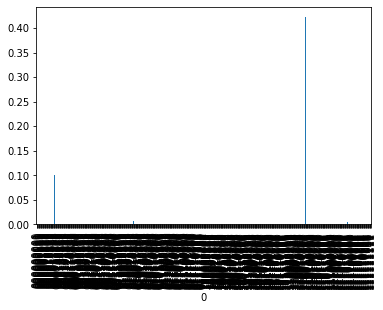

In [17]:

df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: x.real**2 + x.imag**2)
df.set_index(0).module.plot(kind='bar')

In [18]:
df['lambda']=df[0].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1.sort_values('module')

,module
lambda,
1000110,0.000006
0011010,0.000006
1011010,0.000006
1101010,0.000006
0101010,0.000006
...,...
0111011,0.002473
1101011,0.007431
1011011,0.010988


In [333]:
df.columns=['state','st','module','lambda']
df

,state,st,module,lambda
0,000000000,0.0449-0.0448j,0.004023,0000000
1,000000001,0.0014+0.0013j,0.000004,0000001
2,000000010,0.0027-0.0001j,0.000007,0000010
3,000000011,0.0001+0.0029j,0.000008,0000011
4,000000100,0.0044-0.0020j,0.000023,0000100
...,...,...,...,...
507,111111011,-0.0034+0.0095j,0.000102,1111011
508,111111100,0.0054-0.0003j,0.000029,1111100
509,111111101,0.0003+0.0054j,0.000029,1111101
510,111111110,0.0028+0.0026j,0.000015,1111110


In [334]:
df.query("state.str.endswith('0111111')")

,state,st,module,lambda
63,000111111,-0.0717+0.0827j,0.011980,0111111
191,010111111,-0.1004+0.1143j,0.023145,0111111
319,100111111,-0.1004+0.1143j,0.023145,0111111
447,110111111,-0.1391+0.1595j,0.044789,0111111


In [335]:
a1=np.array(df.query("state.str.endswith('0111111')")['module'].values)
a_1_sqrt=np.sqrt(a1)

In [336]:
a2=np.array(df.query("state.str.endswith('1111111')")['module'].values)
a_2_sqrt=np.sqrt(a2)

In [337]:
a=[a_1_sqrt,a_2_sqrt]
#a=[a1,a2]
a

[array([0.10945401, 0.15213366, 0.15213366, 0.21163426]),
 array([0.30252988, 0.4208413 , 0.4208413 , 0.58542429])]

In [338]:
int('0111111'[::-1],base=2)/(2**resolution),int('1111111'[::-1],base=2)/(2**resolution)

(0.984375, 0.9921875)

In [339]:
np.linalg.eig(example_matrix1)

(array([0.0098868, 0.9901132]),
 array([[-0.81195046, -0.58372635],
        [ 0.58372635, -0.81195046]]))

In [340]:
for i in a:
    print(i)
    normalization_factor=np.sqrt((1/(sum(i**2))))
    print(normalization_factor)
    i*=normalization_factor
    print(a)

[0.10945401 0.15213366 0.15213366 0.21163426]
3.114999685709786
[array([0.3409492 , 0.4738963 , 0.4738963 , 0.65924065]), array([0.30252988, 0.4208413 , 0.4208413 , 0.58542429])]
[0.30252988 0.4208413  0.4208413  0.58542429]
1.1261855901192184
[array([0.3409492 , 0.4738963 , 0.4738963 , 0.65924065]), array([0.34070479, 0.47394541, 0.47394541, 0.6592964 ])]


In [454]:
np.sqrt(0.66233483)*(0.46963295/0.66233483)

0.5770583944023632

$$\left|00\right\rangle(0.34722835|00\rangle+0.46924342|01\rangle+0.46924342|10\rangle+0.66261128|11\rangle) =$$

$$\left|00\right\rangle(0.46924342|0\rangle(0.7399|0\rangle+|1\rangle)+0.66261|1\rangle(0.70|0\rangle+|1\rangle)) =$$

$$\sqrt{0.66261}=0.8140 -> posizione 1$$ 

$$0.8140*0.70=0.569 -> posizione 0$$


$$\left|11\right\rangle(0.33486214|00\rangle+0.47763248|01\rangle+0.47763248|10\rangle+0.65696406|11\rangle) =$$

$$\left|11\right\rangle(0.47763248|0\rangle(0.70|0\rangle+|1\rangle)+0.65696406|1\rangle(0.72|0\rangle+|1\rangle)) =$$

$$\sqrt{0.65696406}=0.8105 -> posizione 1$$ 

$$0.8140*0.70=0.58 -> posizione 0$$




seed=1234

$$\left|10\right\rangle(\frac{1}{2}|00\rangle+\frac{1}{2}|01\rangle+\frac{1}{2}|10\rangle+\frac{1}{2}|11\rangle) =$$

$$\left|10\right\rangle(\frac{1}{2}|0\rangle(|0\rangle+|1\rangle)+\frac{1}{2}|1\rangle(|0\rangle+|1\rangle)) =$$

$$\sqrt{\frac{1}{2}}=\frac{1}{\sqrt{2}} -> posizione 0$$ 

$$\frac{1}{\sqrt{2}}*1=\frac{1}{\sqrt{2}} -> posizione 1$$


$$\left|11\right\rangle(0.33486214|00\rangle+0.47763248|01\rangle+0.47763248|10\rangle+0.65696406|11\rangle) =$$

$$\left|11\right\rangle(0.47763248|0\rangle(0.70|0\rangle+|1\rangle)+0.65696406|1\rangle(0.72|0\rangle+|1\rangle)) =$$

$$\sqrt{0.65696406}=0.8105 -> posizione 1$$ 

$$0.8140*0.70=0.58 -> posizione 0$$




seed=1234

In [516]:
np.linalg.eig(example_matrix1)

(array([0.0098868, 0.9901132]),
 array([[-0.81195046, -0.58372635],
        [ 0.58372635, -0.81195046]]))

# Second example (seed=14)

In [60]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

<AxesSubplot: xlabel='0'>

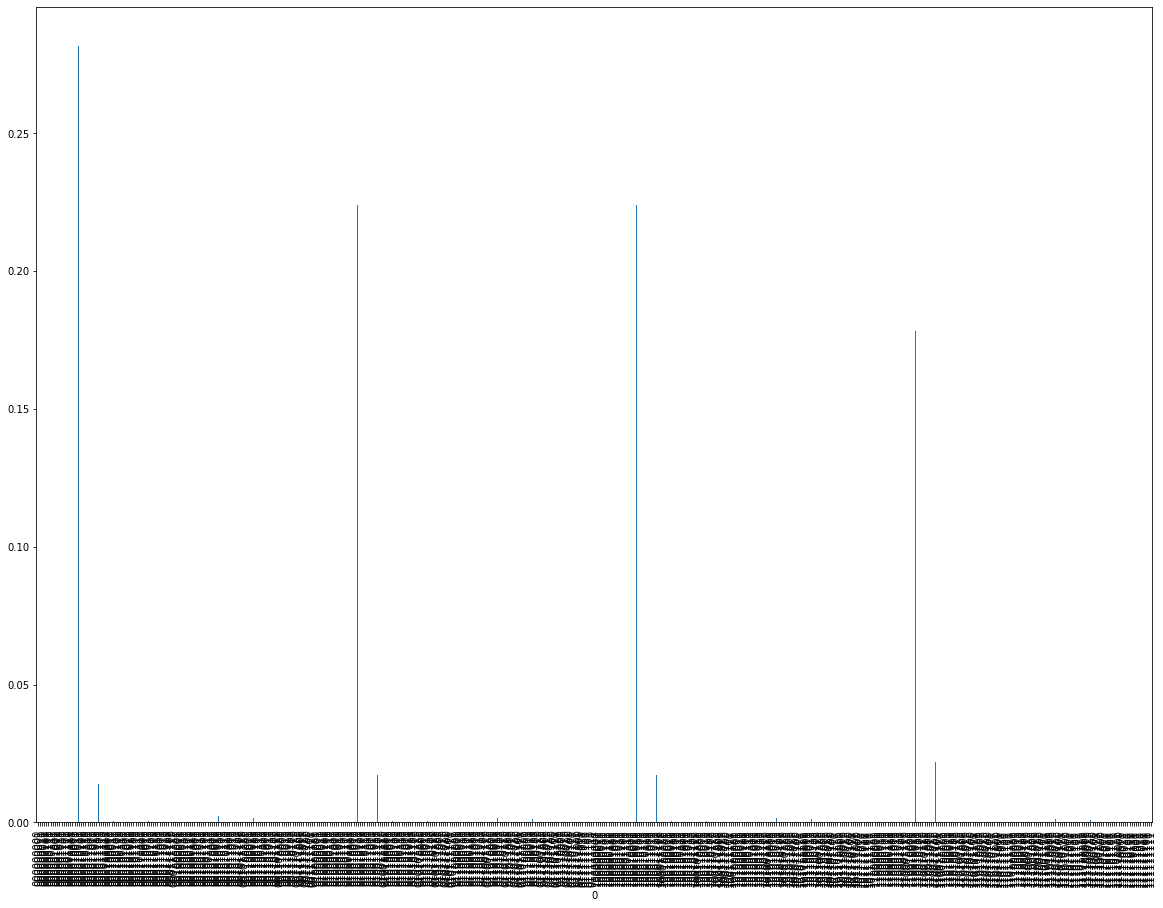

In [61]:
import pandas as pd
df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: x.real**2 + x.imag**2)
df.set_index(0).module.plot(kind='bar',figsize=(20,15))

In [62]:
df

,0,1,module
0,000000000,-0.0012-0.0011j,0.000003
1,000000001,0.0014-0.0006j,0.000002
2,000000010,0.0025-0.0014j,0.000008
3,000000011,0.0106+0.0019j,0.000116
4,000000100,-0.0010-0.0007j,0.000001
...,...,...,...
507,111111011,-0.0028-0.0013j,0.000010
508,111111100,0.0040-0.0016j,0.000019
509,111111101,0.0068+0.0012j,0.000048
510,111111110,0.0012-0.0004j,0.000002


In [63]:
df['lambda']=df[0].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1.sort_values('module')

,module
lambda,
1110110,0.000005
1010110,0.000005
0000110,0.000005
1000110,0.000005
1111010,0.000005
...,...
0110011,0.001647
1100011,0.005189
1010011,0.007192


In [64]:
df.columns=['state','st','module','lambda']
df

,state,st,module,lambda
0,000000000,-0.0012-0.0011j,0.000003,0000000
1,000000001,0.0014-0.0006j,0.000002,0000001
2,000000010,0.0025-0.0014j,0.000008,0000010
3,000000011,0.0106+0.0019j,0.000116,0000011
4,000000100,-0.0010-0.0007j,0.000001,0000100
...,...,...,...,...
507,111111011,-0.0028-0.0013j,0.000010,1111011
508,111111100,0.0040-0.0016j,0.000019,1111100
509,111111101,0.0068+0.0012j,0.000048,1111101
510,111111110,0.0012-0.0004j,0.000002,1111110


In [67]:
df.query("state.str.endswith('0011100')")

,state,st,module,lambda
28,000011100,0.1140-0.0307j,0.013938,0011100
156,010011100,-0.1277+0.0323j,0.017351,0011100
284,100011100,-0.1277+0.0323j,0.017351,0011100
412,110011100,0.1433-0.0382j,0.021994,0011100


In [69]:
df.query("state.str.endswith('0010011')")

,state,st,module,lambda
19,000010011,0.5136+0.1340j,0.281741,0010011
147,010010011,0.4579+0.1190j,0.223833,0010011
275,100010011,0.4579+0.1190j,0.223833,0010011
403,110010011,0.4084+0.1066j,0.178154,0010011


In [71]:
a1=np.array(df.query("state.str.endswith('0011100')")['module'].values)
a1,sum(a1)
a_1_sqrt=np.sqrt(a1)

In [72]:
a2=np.array(df.query("state.str.endswith('0010011')")['module'].values)
a2,sum(a2)
a_2_sqrt=np.sqrt(a2)

In [73]:
a=[a_1_sqrt,a_2_sqrt]
#a=[a1,a2]
a

[array([0.11806138, 0.1317216 , 0.1317216 , 0.14830418]),
 array([0.53079277, 0.47311036, 0.47311036, 0.42208307])]

In [74]:
int('0011100'[::-1],base=2)/(2**resolution),int('0010011'[::-1],base=2)/(2**resolution)

(0.21875, 0.78125)

In [75]:
np.linalg.eig(example_matrix1)

(array([0.78188847, 0.21811153]),
 array([[ 0.7463677 , -0.66553381],
        [ 0.66553381,  0.7463677 ]]))

In [357]:
for i in a:
    print(i)
    normalization_factor=np.sqrt((1/(sum(i**2))))
    print(normalization_factor)
    i*=normalization_factor
    print(a)

[0.38706612 0.34515869 0.34515869 0.30779036]
1.4391481917317492
[array([0.5570455 , 0.49673451, 0.49673451, 0.44295594]), array([0.16249386, 0.18244004, 0.18244004, 0.20437186])]
[0.16249386 0.18244004 0.18244004 0.20437186]
2.7242712973456475
[array([0.5570455 , 0.49673451, 0.49673451, 0.44295594]), array([0.44267737, 0.49701617, 0.49701617, 0.55676439])]


$$\left|11100\right\rangle(0.44267737|00\rangle+0.49701617|01\rangle+0.49701617|10\rangle+0.55676439|11\rangle) =$$

$$\left|11100\right\rangle(0.49701617|0\rangle(0.89|0\rangle+|1\rangle)+0.55676439|1\rangle(0.89|0\rangle+|1\rangle)) =$$

$$\sqrt{0.55676439}=0.7461 -> posizione 1$$ 

$$0.7461*0.89=0.66609 -> posizione 0$$



$$\left|10011\right\rangle(0.5570455|00\rangle+0.49673451|01\rangle+0.49673451|10\rangle+0.44295594|11\rangle) =$$

$$\left|10011\right\rangle(0.5570455|0\rangle(|0\rangle+0.89|1\rangle)+0.49673451|1\rangle(|0\rangle+0.89|1\rangle)) =$$

$$\sqrt{0.5570455}=0.7463 -> posizione 0$$ 

$$0.788*0.63=0.6642 -> posizione 1$$




seed=14

In [197]:
np.linalg.eig(example_matrix1)

(array([0.78188847, 0.21811153]),
 array([[ 0.7463677 , -0.66553381],
        [ 0.66553381,  0.7463677 ]]))

# 3 example (seed=26)

In [207]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix2))))]
ss=attach_bitstrings(statevector)
#ss

In [458]:
df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: x.real**2 + x.imag**2)
#df.set_index(0).module.plot(kind='bar')

In [459]:
df['lambda']=df[0].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1.sort_values('module')
#int('10011'[::-1],base=2)/32

,module
lambda,
1000001,0.000033
0111110,0.000033
1011110,0.000033
0000001,0.000033
0011110,0.000033
...,...
1000000,0.010851
1011111,0.018309
0000000,0.034524


In [461]:
int('0111111'[::-1],base=2)/(2**resolution),int('1111111'[::-1],base=2)/(2**resolution)

(0.984375, 0.9921875)

In [462]:
np.linalg.eig(example_matrix1)

(array([0.00987623, 0.99012377]),
 array([[-0.87996277, -0.47504266],
        [ 0.47504266, -0.87996277]]))

In [263]:
eig_qubits=df.loc[df.head(4)['module'].nlargest(2).index][0].str[-2:]
eig_qubits

0    00
3    11
Name: 0, dtype: object

In [264]:
for i in eig_qubits:
    df1=df[df[0].str.endswith(str(i))]
    l=df1['module'].values
    print(i, l)
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor
    print(i,l)

00 [0.23267849 0.41285568 0.41285568 0.7746162 ]
00 [0.23325427 0.41387732 0.41387732 0.77653305]
11 [0.00987168 0.01910314 0.01910314 0.03494138]
11 [0.21812411 0.42210213 0.42210213 0.77206312]


$$\left|00\right\rangle(0.23325427|00\rangle+0.41387732|01\rangle+0.41387732|10\rangle+0.77653305|11\rangle) =$$

$$\left|00\right\rangle(0.41387732|0\rangle(.56|0\rangle+|1\rangle)+0.77653305|1\rangle(.53|0\rangle+|1\rangle)) =$$

$$\sqrt{0.77653305}=0.8812 -> posizione 1$$ 

$$0.88*0.53=0.4670 -> posizione 0$$


$$\left|11\right\rangle(0.21812411|00\rangle+0.42210213|01\rangle+0.42210213|10\rangle+0.77206312|11\rangle) =...$$





seed=26

In [270]:
np.linalg.eig(example_matrix1)

(array([0.00987623, 0.99012377]),
 array([[-0.87996277, -0.47504266],
        [ 0.47504266, -0.87996277]]))

# 4X4 Seed=12

In [510]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

<AxesSubplot: xlabel='0'>

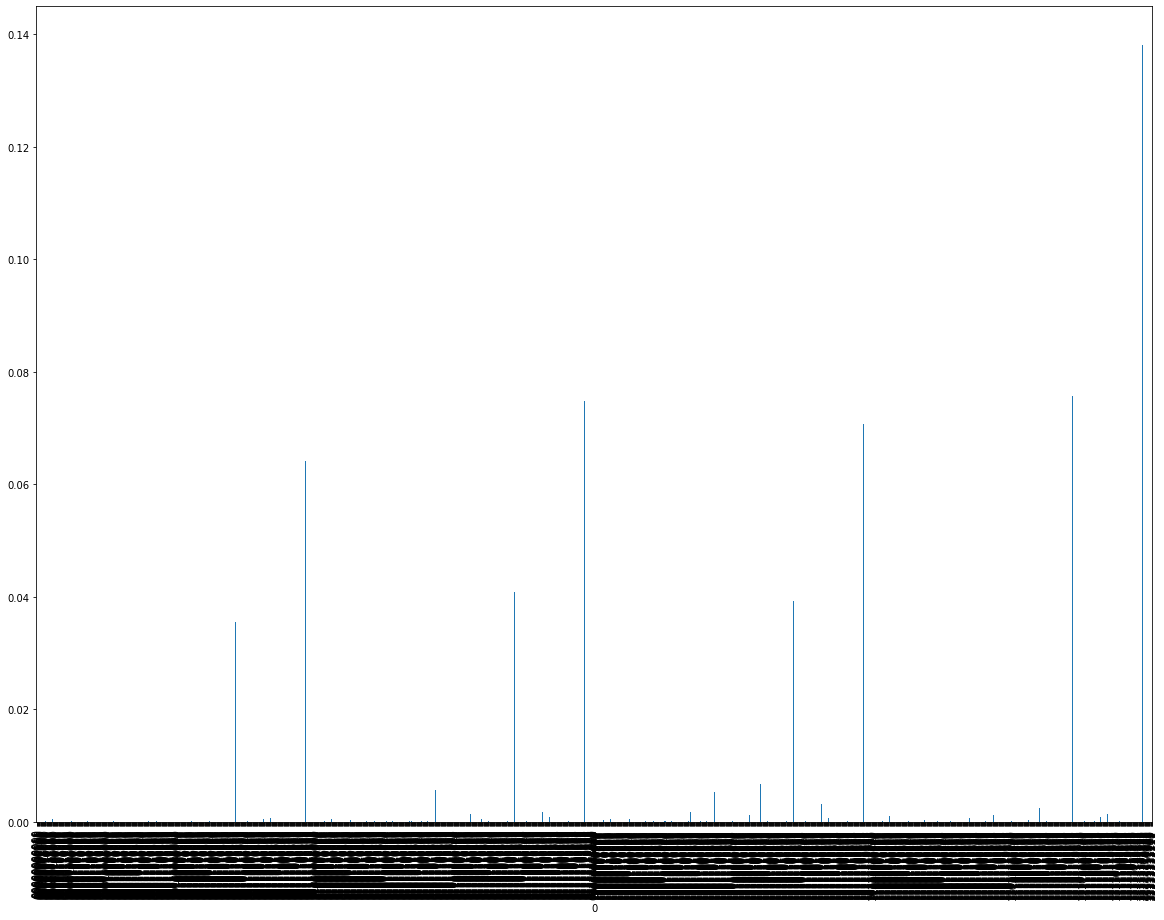

In [511]:
import pandas as pd
df=pd.DataFrame(ss)
df['module']=df[1].apply(lambda x: x.real**2 + x.imag**2)
df.set_index(0).module.plot(kind='bar',figsize=(20,15))

In [512]:
df['lambda']=df[0].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1.sort_values('module')

,module
lambda,
0001110,0.000019
0110110,0.000019
1010110,0.000019
1001110,0.000019
1110110,0.000019
...,...
0011101,0.013616
1011100,0.019972
0110000,0.020496


In [513]:
df.columns=['state','st','module','lambda']
df

,state,st,module,lambda
0,00000000000,0.0024+0.0034j,1.732000e-05,0000000
1,00000000001,0.0009-0.0004j,9.700000e-07,0000001
2,00000000010,0.0002-0.0004j,2.000000e-07,0000010
3,00000000011,-0.0032-0.0017j,1.313000e-05,0000011
4,00000000100,-0.0001-0.0014j,1.970000e-06,0000100
...,...,...,...,...
2043,11111111011,-0.0011-0.0014j,3.170000e-06,1111011
2044,11111111100,-0.0001+0.0010j,1.010000e-06,1111100
2045,11111111101,-0.0094-0.0046j,1.095200e-04,1111101
2046,11111111110,0.0015-0.0006j,2.610000e-06,1111110


In [18]:
a1=np.array(df.query("state.str.endswith('1101101')")['module'].values)
a1,sum(a1)
a_1_sqrt=np.sqrt(a1)

In [19]:
a2=np.array(df.query("state.str.endswith('0100000')")['module'].values)
a2,sum(a1)
a_2_sqrt=np.sqrt(a2)

In [20]:
a3=np.array(df.query("state.str.endswith('0110000')")['module'].values)
a3,sum(a3)
a_3_sqrt=np.sqrt(a3)

In [21]:
a4=np.array(df.query("state.str.endswith('1011100')")['module'].values)
a4,sum(a4)
a_4_sqrt=np.sqrt(a4)

In [22]:
a=[a_1_sqrt,a_2_sqrt,a_3_sqrt,a_4_sqrt]
#a=[a1,a2]
a

[array([0.17170073, 0.17736496, 0.18827538, 0.25341138, 0.1844218 ,
        0.19247922, 0.20216689, 0.27355749, 0.18058641, 0.18540423,
        0.19814338, 0.2659364 , 0.25084836, 0.26068235, 0.2752061 ,
        0.37162069]),
 array([0.03301348, 0.01222988, 0.00907359, 0.02253752, 0.06707406,
        0.02332381, 0.02042866, 0.04194878, 0.08521766, 0.0310601 ,
        0.02452468, 0.05611702, 0.04666615, 0.01534959, 0.01423938,
        0.02840035]),
 array([0.00345254, 0.0005099 , 0.00224722, 0.0021095 , 0.01609627,
        0.01172092, 0.02200818, 0.01481891, 0.05105487, 0.04210428,
        0.08168843, 0.0564985 , 0.03009585, 0.02551255, 0.0492123 ,
        0.03392713]),
 array([0.00264764, 0.01317953, 0.00933916, 0.00586941, 0.0190683 ,
        0.07555713, 0.04768197, 0.02863564, 0.01730029, 0.07274868,
        0.04762709, 0.02920976, 0.00863481, 0.03389543, 0.0206526 ,
        0.01184567])]

In [24]:
int('1101101'[::-1],base=2)/(2**resolution),int('0100000'[::-1],base=2)/(2**resolution),int('0110000'[::-1],base=2)/(2**resolution),int('1011100'[::-1],base=2)/(2**resolution)

(0.7109375, 0.015625, 0.046875, 0.2265625)

In [25]:
np.linalg.eig(example_matrix1)

(array([0.71180655, 0.22316477, 0.01821782, 0.04681086]),
 array([[ 0.42777602,  0.20326857,  0.78671927,  0.39593227],
        [ 0.44316532,  0.78097832, -0.26649827, -0.35022284],
        [ 0.46933345, -0.50082482,  0.22263581, -0.69233945],
        [ 0.63272292, -0.31293648, -0.51037708,  0.49116972]]))

In [26]:
for i in a:
    print(i)
    normalization_factor=np.sqrt((1/(sum(i**2))))
    print(normalization_factor)
    i*=normalization_factor
    print(a)

[0.17170073 0.17736496 0.18827538 0.25341138 0.1844218  0.19247922
 0.20216689 0.27355749 0.18058641 0.18540423 0.19814338 0.2659364
 0.25084836 0.26068235 0.2752061  0.37162069]
1.0726928707065038
[array([0.18418215, 0.19025813, 0.20196166, 0.27183259, 0.19782795,
       0.20647109, 0.21686298, 0.29344317, 0.19371375, 0.1988818 ,
       0.21254699, 0.28526808, 0.26908325, 0.2796321 , 0.29521163,
       0.39863487]), array([0.03301348, 0.01222988, 0.00907359, 0.02253752, 0.06707406,
       0.02332381, 0.02042866, 0.04194878, 0.08521766, 0.0310601 ,
       0.02452468, 0.05611702, 0.04666615, 0.01534959, 0.01423938,
       0.02840035]), array([0.00345254, 0.0005099 , 0.00224722, 0.0021095 , 0.01609627,
       0.01172092, 0.02200818, 0.01481891, 0.05105487, 0.04210428,
       0.08168843, 0.0564985 , 0.03009585, 0.02551255, 0.0492123 ,
       0.03392713]), array([0.00264764, 0.01317953, 0.00933916, 0.00586941, 0.0190683 ,
       0.07555713, 0.04768197, 0.02863564, 0.01730029, 0.07274868,
 

In [40]:
df.query("state.str.endswith('1101101')")

,state,st,module,lambda
109,00001101101,0.1615+0.0583j,0.029481,1101101
237,00011101101,0.1668+0.0603j,0.031458,1101101
365,00101101101,0.1771+0.0639j,0.035448,1101101
493,00111101101,0.2383+0.0862j,0.064217,1101101
621,01001101101,0.1734+0.0628j,0.034011,1101101
749,01011101101,0.1811+0.0652j,0.037048,1101101
877,01101101101,0.1901+0.0688j,0.040871,1101101
1005,01111101101,0.2573+0.0929j,0.074834,1101101
1133,10001101101,0.1699+0.0612j,0.032611,1101101
1261,10011101101,0.1743+0.0632j,0.034375,1101101


Autovalore 1101101 =>0.71

$$\left|1101101\right\rangle(0.18418215|0000\rangle+0.19025813|0001\rangle+0.20196166|0010\rangle+0.27183259|0011\rangle+
0.19782795|0100\rangle+0.20647109|0101\rangle+0.21686298|0110\rangle+0.29344317|0111\rangle+0.19371375|1000\rangle+0.1988818|1001\rangle+0.21254699|1010\rangle+0.28526808|1011\rangle+
0.26908325|1100\rangle+0.2796321|1101\rangle+0.29521163|1110\rangle+0.39863487|1111\rangle) =$$

$$\left|1101101\right\rangle\left[\textbf{...|00}\rangle(...|00\rangle+...|01\rangle+...|10\rangle+|11\rangle)+\\
\textbf{...|01}\rangle(...|00\rangle+...|01\rangle+...|10\rangle+|11\rangle)+\\
\textbf{...|10}\rangle(...|00\rangle+...|01\rangle+...|10\rangle+|11\rangle)+\\
\textbf{0.39863|11}\rangle(0.6750|00\rangle+0.7014|01\rangle+0.74055|10\rangle+|11\rangle)\right]\\
$$

$$\sqrt{.39863}=.6313 -> 4 posizione 
\\
0.6313*0.6750=0.4261-> 1 posizione
\\
0.6313*0.7014=0.44289 -> 2 posizione
\\
0.6313*0.74055=0.4675 -> 3 posizione
$$

Guardando lo statevector si vede tutti segni positivi=> tutti i valori dell'autovettore saranno positivi

In [41]:
df.query("state.str.endswith('0100000')")

,state,st,module,lambda
32,00000100000,0.0170+0.0283j,0.001090,0100000
160,00010100000,-0.0061-0.0106j,0.000150,0100000
288,00100100000,0.0048+0.0077j,0.000082,0100000
416,00110100000,-0.0113-0.0195j,0.000508,0100000
544,01000100000,-0.0342-0.0577j,0.004499,0100000
672,01010100000,0.0120+0.0200j,0.000544,0100000
800,01100100000,-0.0102-0.0177j,0.000417,0100000
928,01110100000,0.0217+0.0359j,0.001760,0100000
1056,10000100000,0.0438+0.0731j,0.007262,0100000
1184,10010100000,-0.0157-0.0268j,0.000965,0100000


Autovalore 0100000 => 0.015

$$\left|0100000\right\rangle(0.21113212|0000\rangle+0.07821413|0001\rangle+0.05802859|0010\rangle+0.14413491|0011\rangle+
0.42896078|0100\rangle+0.14916345|0101\rangle+0.130648|0110\rangle+0.26827628|0111\rangle+0.54499508|1000\rangle+0.19863961|1001\rangle+0.15684343|1010\rangle+0.35888687|1011\rangle+
0.29844546|1100\rangle+0.09816571|1101\rangle+0.09106555|1110\rangle+0.18162963|1111\rangle) =$$

$$\left|1101101\right\rangle\left[\textbf{...|00}\rangle(...|00\rangle+...|01\rangle+...|10\rangle+|11\rangle)+\\
\textbf{...|01}\rangle(...|00\rangle+...|01\rangle+...|10\rangle+|11\rangle)+\\
\textbf{.54499508|10}\rangle(|00\rangle+0.3644|01\rangle+ 0.2877|10\rangle+0.6585|11\rangle)+\\
\textbf{...|11}\rangle(...|00\rangle+...|01\rangle+...|10\rangle+...|11\rangle)\right]\\
$$

$$\sqrt{.54499508}=.7382 -> 1 posizione 
\\
0.7382*0.3644=0.2690-> 2 posizione
\\
0.7382*0.2877=0.2124 -> 3 posizione
\\
0.7382*0.6585=0.4861 -> 4 posizione
$$

I segni sono alternati con + e - =>> coppia di segni negativi alterni

$$\left|0100000\right\rangle((+...+j)|0000\rangle+(-...-j)|0001\rangle+(+...+j)|0010\rangle+(-...-j)|0011\rangle+
(-...-j)|0100\rangle+(+...+j)|0101\rangle+(-...-j)|0110\rangle+(+...+j)|0111\rangle+\textbf{(+...+j)}\textbf{|1000}\rangle+\textbf{(-...-j)|1001}\rangle+\textbf{(+...+j)|1010}\rangle+\textbf{(-...-j)|1011}\rangle+
(-...-j)|1100\rangle+(+...+j)|1101\rangle+(-...-j)|1110\rangle+(+...+j)|1111\rangle) =$$

Si guarda sempre il segno della parte reale-> segni alterni +-+- o -+-+

In [42]:
df.query("state.str.endswith('1011100')")

,state,st,module,lambda
92,00001011100,-0.0005+0.0026j,0.000007,1011100
220,00011011100,-0.0027+0.0129j,0.000174,1011100
348,00101011100,0.0021-0.0091j,0.000087,1011100
476,00111011100,0.0014-0.0057j,0.000034,1011100
604,01001011100,0.0042-0.0186j,0.000364,1011100
732,01011011100,0.0162-0.0738j,0.005709,1011100
860,01101011100,-0.0101+0.0466j,0.002274,1011100
988,01111011100,-0.0060+0.0280j,0.000820,1011100
1116,10001011100,-0.0037+0.0169j,0.000299,1011100
1244,10011011100,-0.0154+0.0711j,0.005292,1011100


$$\left|1011100\right\rangle((-...+j)|0000\rangle+(-...+j)|0001\rangle+(+...-j)|0010\rangle+(+...-j)|0011\rangle+
(+...-j)|0100\rangle+(+...-j)|0101\rangle+(-...+j)|0110\rangle+(-...+j)|0111\rangle+\textbf{(-...+j)}\textbf{|1000}\rangle+\textbf{(-...+j)|1001}\rangle+\textbf{(+...-j)|1010}\rangle+\textbf{(+...-j)|1011}\rangle+
(+...-j)|1100\rangle+(+...-j)|1101\rangle+(-...+j)|1110\rangle+(-...+j)|1111\rangle) =$$

Si guarda sempre il segno della parte reale (o della parte immaginaria)-> segni concordi ++-- o --++ 

Per i segni: a vedere dallo statevector, sembra che se abbiamo valori con parte reale negativa e parte immaginaria positiva seguiti da valori con parte reale positiva e parte immaginaria negativa=> segni concordi.
Invece, se vediamo parte reale e immaginaria negativa insieme=> segni discordi

Da Verificare meglio!!!

In [27]:
df.query("state.str.endswith('0110000')")

,state,st,module,lambda
48,00000110000,-0.0006-0.0034j,1.192000e-05,0110000
176,00010110000,-0.0005+0.0001j,2.600000e-07,0110000
304,00100110000,-0.0019-0.0012j,5.050000e-06,0110000
432,00110110000,0.0018+0.0011j,4.450000e-06,0110000
560,01000110000,0.0153+0.0050j,2.590900e-04,0110000
688,01010110000,-0.0117-0.0007j,1.373800e-04,0110000
816,01100110000,-0.0220+0.0006j,4.843600e-04,0110000
944,01110110000,0.0138-0.0054j,2.196000e-04,0110000
1072,10000110000,-0.0506-0.0068j,2.606600e-03,0110000
1200,10010110000,0.0421-0.0006j,1.772770e-03,0110000


In [638]:
np.linalg.eig(example_matrix1)

(array([0.71180655, 0.22316477, 0.01821782, 0.04681086]),
 array([[ 0.42777602,  0.20326857,  0.78671927,  0.39593227],
        [ 0.44316532,  0.78097832, -0.26649827, -0.35022284],
        [ 0.46933345, -0.50082482,  0.22263581, -0.69233945],
        [ 0.63272292, -0.31293648, -0.51037708,  0.49116972]]))

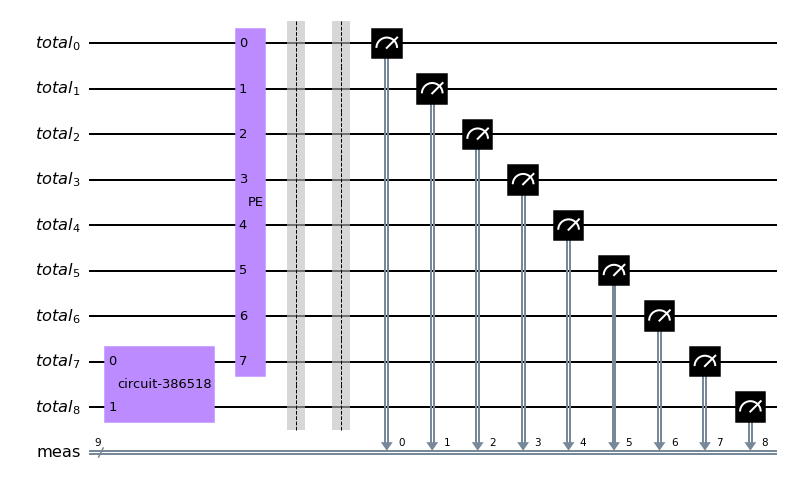

In [539]:
tot_qubit = resolution+len(example_matrix1)

qr_total = QuantumRegister(tot_qubit, 'total')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
total_circuit.barrier()

total_circuit.measure_all()
total_circuit.draw("mpl")

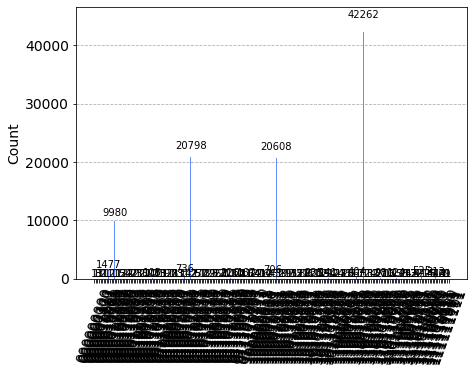

In [540]:
n_shots=100000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [541]:
for i in counts:
    counts[i]/=n_shots
#counts

In [542]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
#statevector

In [543]:
#Create second operator tomography
op_V = StatePreparation(np.sqrt(statevector),label='c_V').control()

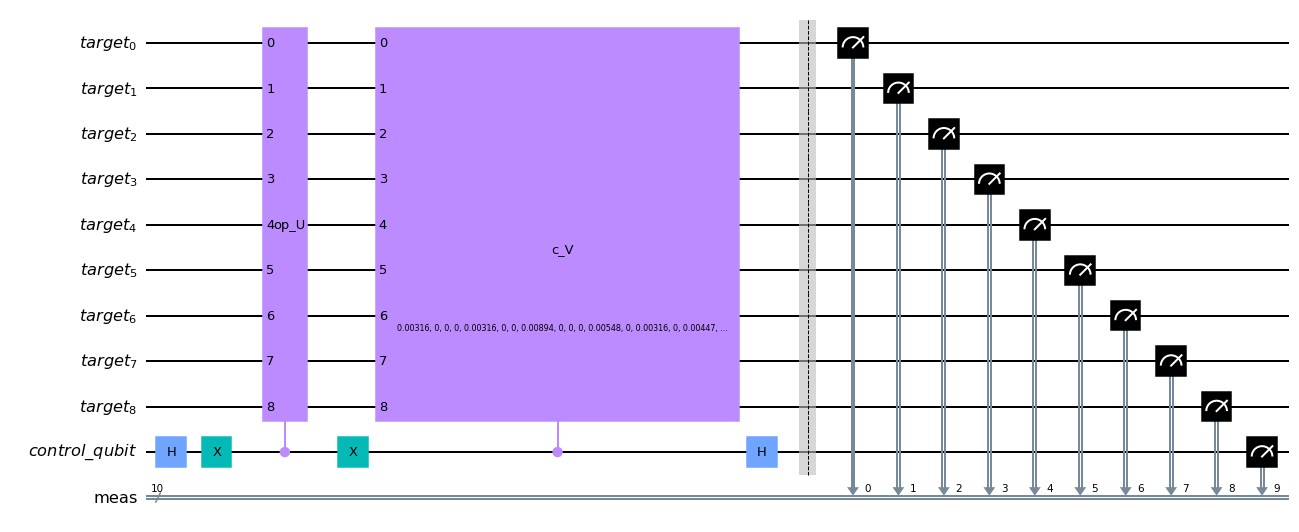

In [544]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'target')
qr_control = QuantumRegister(1, 'control_qubit')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_control, name='matrix')
total_circuit_2.h(qr_control)
total_circuit_2.x(qr_control)
total_circuit_2.append(op_U, qr_control[:]+qr_total_xi[:])
total_circuit_2.x(qr_control)
total_circuit_2.append(op_V, qr_control[:]+qr_total_xi[:])
total_circuit_2.h(qr_control)
total_circuit_2.measure_all()
total_circuit_2.draw("mpl")

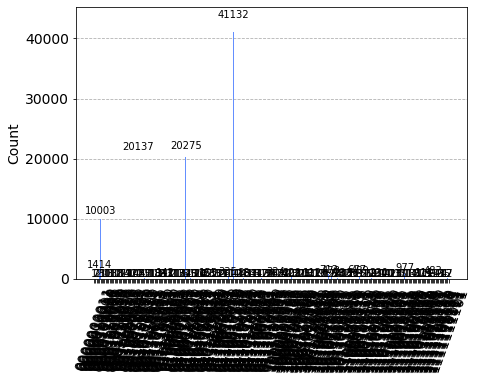

In [545]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [546]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
#tmp

In [547]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [548]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

#statevector_dictionary

In [684]:
'''ok=[]
ko=[]
for e,i in enumerate(sign_dictionary):
    if sign_dictionary[i]==np.sign(ss[e][1].real):
        ok.append(i)
    else:
        ko.append(i)
    
len(ko),len(ok)        '''

In [241]:
###Metodo Nannicini

tmp_=tmp/(sum(tmp))

sign_diff=[]
sign=[]
x_list=[]
for i in range(len(tmp_)):
    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))
    
    x_list.append(x)
    
    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))
    sign.append(np.sign(x))
    

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_1540/2527842937.py:9: RuntimeWarning: invalid value encountered in double_scalars
  x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))
/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_1540/2527842937.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))


In [138]:
x_real_list=[h[1].real for h in ss]

In [57]:
df_sign=pd.DataFrame({'x':x_list,'x_real':x_real_list}).fillna(0)
df_sign

,x,x_real
0,0.300129,0.11065
1,0.005164,0.00020
2,0.012649,0.00020
3,-0.004243,0.00020
4,0.023452,0.00065
...,...,...
59,-0.023479,0.00130
60,0.032426,0.00090
61,-0.003322,0.00050
62,0.010791,0.00040


In [58]:
df_sign['sign']=np.sign(df_sign['x'].values)+np.sign(df_sign['x_real'].values)
df_sign

,x,x_real,sign
0,0.300129,0.11065,2.0
1,0.005164,0.00020,2.0
2,0.012649,0.00020,2.0
3,-0.004243,0.00020,0.0
4,0.023452,0.00065,2.0
...,...,...,...
59,-0.023479,0.00130,0.0
60,0.032426,0.00090,2.0
61,-0.003322,0.00050,0.0
62,0.010791,0.00040,2.0


In [59]:
df_sign['sign'].value_counts()

2.0    41
0.0    21
1.0     2
Name: sign, dtype: int64

In [549]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

In [550]:
df=pd.DataFrame(ss)
#df['module']=df[1].apply(lambda x: x.real**2 + x.imag**2)
#df.set_index(0).module.plot(kind='bar')
df.columns=['state','module']
df
df

,state,module
0,000000000,0.00001
1,000000001,0.00000
2,000000010,0.00000
3,000000011,0.00000
4,000000100,0.00001
...,...,...
507,111111011,0.00049
508,111111100,0.00000
509,111111101,0.00001
510,111111110,0.00000


In [551]:
df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module')
df1

,module
lambda,
0101010,0.00000
1101110,0.00000
1101100,0.00000
0100101,0.00000
0100110,0.00000
...,...
0111011,0.00241
1101011,0.00694
1011011,0.01091


In [552]:
lambdas=df1.tail(len(example_matrix1)).index.values

In [553]:
lambdas

array(['0010100', '0011011'], dtype=object)

In [554]:
df.columns=['state','module','lambda']
df

,state,module,lambda
0,000000000,0.00001,0000000
1,000000001,0.00000,0000001
2,000000010,0.00000,0000010
3,000000011,0.00000,0000011
4,000000100,0.00001,0000100
...,...,...,...
507,111111011,0.00049,1111011
508,111111100,0.00000,1111100
509,111111101,0.00001,1111101
510,111111110,0.00000,1111110


In [382]:
np.sqrt((0.1615-0.03041)**2+0.0583**2)

0.14346943263287829

In [555]:
df['sign']=np.array(list(sign_dictionary.values()))
#df['sign']=np.array(sign)
df

,state,module,lambda,sign
0,000000000,0.00001,0000000,-1
1,000000001,0.00000,0000001,1
2,000000010,0.00000,0000010,1
3,000000011,0.00000,0000011,1
4,000000100,0.00001,0000100,-1
...,...,...,...,...
507,111111011,0.00049,1111011,-1
508,111111100,0.00000,1111100,1
509,111111101,0.00001,1111101,1
510,111111110,0.00000,1111110,1


In [556]:
df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
#df['module']=df['module'].multiply(np.array(sign), axis=0)
df=df.fillna(0)
df

,state,module,lambda,sign
0,000000000,-0.00001,0000000,-1
1,000000001,0.00000,0000001,1
2,000000010,0.00000,0000010,1
3,000000011,0.00000,0000011,1
4,000000100,-0.00001,0000100,-1
...,...,...,...,...
507,111111011,-0.00049,1111011,-1
508,111111100,0.00000,1111100,1
509,111111101,0.00001,1111101,1
510,111111110,0.00000,1111110,1


In [557]:
a=[]
save_sign=[]
eigenvalues=[]
for l in lambdas:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]

for i in range(len(a)):
    print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]
    
    print(a)

[0.12153189 0.08579044 0.08402381 0.06356099]
5.485735064374616
[array([ 0.66669174, -0.47062364, -0.46093234,  0.34867878]), array([0.31591138, 0.45604824, 0.45396035, 0.6500923 ])]
[0.31591138 0.45604824 0.45396035 0.6500923 ]
1.0333578586508825
[array([ 0.66669174, -0.47062364, -0.46093234,  0.34867878]), array([0.32644951, 0.47126104, 0.4691035 , 0.67177799])]


In [558]:
eigenvalues

[0.15625, 0.84375]

In [559]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(a,eigenvalues):
    
    eigenvector=np.zeros(len(example_matrix1)) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv),len(example_matrix1))):
        max_list.append(max(sv[i:i+len(example_matrix1)]))
        scaled_statevectors.append(sv[i:i+len(example_matrix1)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len(example_matrix1)*idx_max:len(example_matrix1)*idx_max+len(example_matrix1)]
    eigenvectors.append((eig,eigenvector))
    print('reconstructed_eigenvector:',eigenvector)
    print('reconstructed_eigenvalue:', eig)
    

reconstructed_eigenvector: [ 0.81651194 -0.57638305]
reconstructed_eigenvalue: 0.15625
reconstructed_eigenvector: [0.57234222 0.81962064]
reconstructed_eigenvalue: 0.84375


In [560]:
np.linalg.eig(example_matrix1)

(array([0.15548669, 0.84451331]),
 array([[-0.81909218, -0.57366192],
        [ 0.57366192, -0.81909218]]))

In [502]:
0.15625-0.15548669,0.84451331-0.84375

(0.0007633099999999893, 0.0007633099999999615)

In [255]:
zeros=[s for s in sign_diff if s==0]
len(zeros),len(sign_diff)

(150, 512)

In [427]:
1/(2**7)+1/(2**8)

0.01171875

In [259]:
0.5+0.125

0.625

In [197]:
1/2**7

0.0078125

In [256]:
0.75-0.623


0.127

In [257]:
0.5-0.623

-0.123

In [260]:
5/8

0.625